# Find a reasonable rule in cardio dataset

In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys
sys.path.append('..')

import gc
import os
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import utils


df = pd.read_csv(os.path.join('data', 'cardio_train.csv'), delimiter=';')
df = df.drop(['id'], axis=1)

y = df['cardio']
X = df.drop(['cardio'], axis=1)

print("Target class ratio:")
print("# of cardio=1: {}/{} ({:.2f}%)".format(np.sum(y==1), len(y), 100*np.sum(y==1)/len(y)))
print("# of cardio=0: {}/{} ({:.2f}%)".format(np.sum(y==0), len(y), 100*np.sum(y==0)/len(y)))


from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()
# y_true = y_test.copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Target class ratio:
# of cardio=1: 34979/70000 (49.97%)
# of cardio=0: 35021/70000 (50.03%)


In [45]:
X

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1
69996,22601,1,158,126.0,140,90,2,2,0,0,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0
69998,22431,1,163,72.0,135,80,1,2,0,0,0


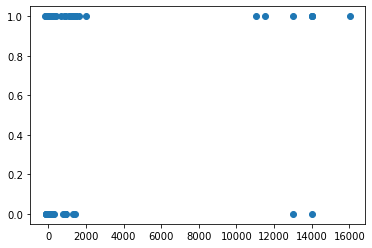

In [49]:
x1 = X['ap_hi'].to_numpy()
target = y

plt.scatter(x1, target)

In [52]:

np.corrcoef(x1, target)

array([[1.        , 0.05447505],
       [0.05447505, 1.        ]])

In [130]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

from utils_cardio import *


fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()
acc_dict = dict()
prec_dict = dict()
recall_dict = dict()
model_types = []

clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)


model_type = 'dtree'
acc_dict[model_type], prec_dict[model_type], recall_dict[model_type], fpr_dict[model_type], tpr_dict[model_type], roc_auc_dict[model_type] = get_metrics(y_true, y_pred, y_score)
print('[{}] Accuracy: {:.2f} %'.format(model_type, 100*acc_dict[model_type]))

[dtree] Accuracy: 71.59 %


In [88]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))

The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 4] <= 129.5 else to node 8.
	node=1 is a split node: go to node 2 if X[:, 0] <= 19996.5 else to node 5.
		node=2 is a split node: go to node 3 if X[:, 6] <= 2.5 else to node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5 is a split node: go to node 6 if X[:, 6] <= 2.5 else to node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8 is a split node: go to node 9 if X[:, 4] <= 138.5 else to node 12.
		node=9 is a split node: go to node 10 if X[:, 6] <= 2.5 else to node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[:, 4] <= 149.5 else to node 14.
			node=13 is a leaf node.
			node=14 is a leaf node.


In [114]:
# X_test = X_test.to_numpy()

node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)
y_pred = clf.predict(X_test)

sample_id = 14
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))
    
print("decision node {node}. Decision: {pred}".format(node=node_id, pred=y_pred[sample_id]))

Rules used to predict sample 14:

decision node 0 : (X_test[14, 4] = 110.0) <= 129.5)
decision node 1 : (X_test[14, 0] = 21936.0) > 19996.5)
decision node 5 : (X_test[14, 6] = 3.0) > 2.5)
decision node 7. Decision: 1


[Text(697.5, 611.55, 'X[4] <= 129.5\ngini = 0.5\nsamples = 56000\nvalue = [28033, 27967]'),
 Text(348.75, 203.85000000000002, 'gini = 0.434\nsamples = 33091\nvalue = [22537, 10554]'),
 Text(1046.25, 203.85000000000002, 'gini = 0.365\nsamples = 22909\nvalue = [5496, 17413]')]

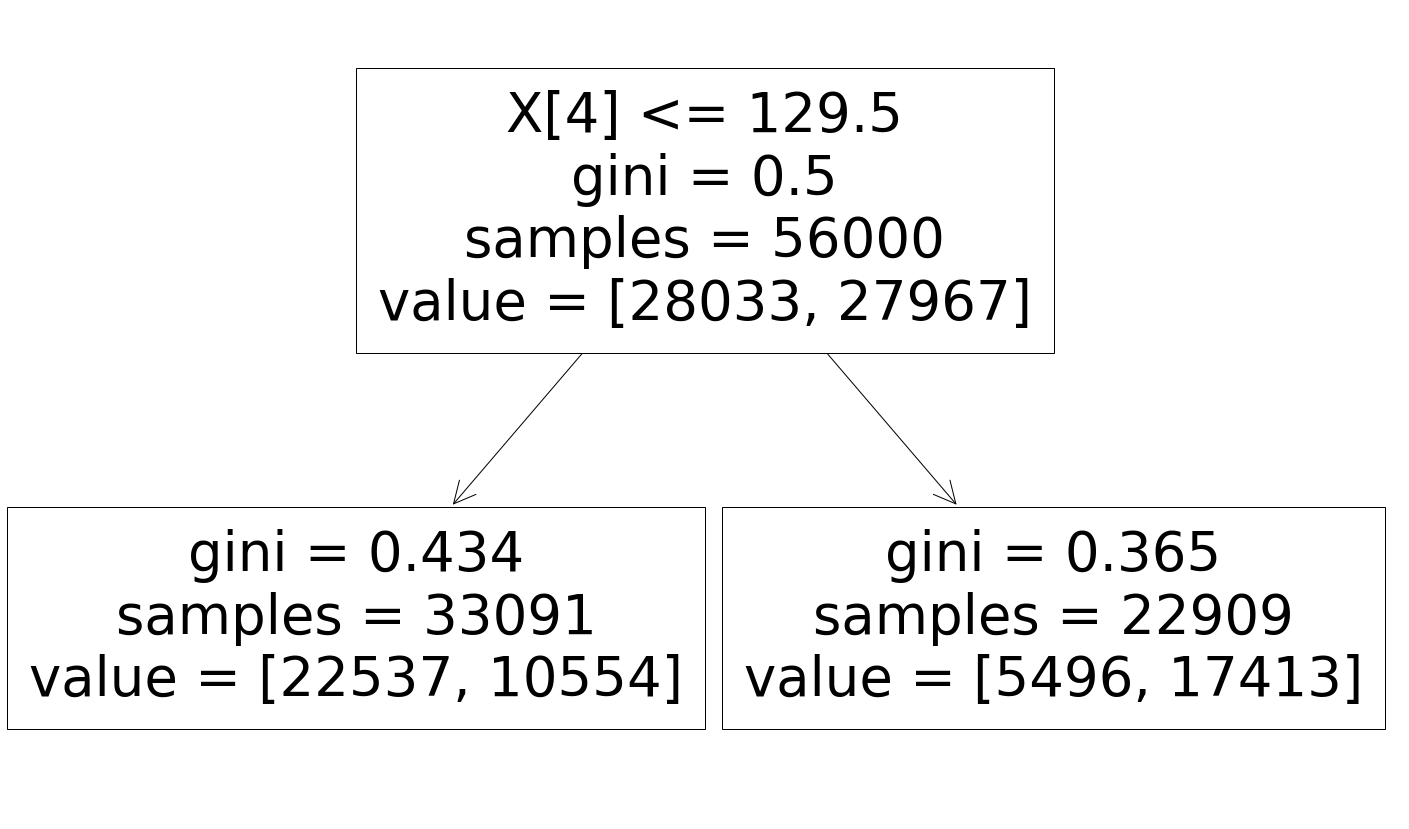

In [132]:
fig, ax = plt.subplots(figsize=(25,15))
plot_tree(clf, ax=ax)

In [87]:
X_train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
47339,21876,1,154,80.0,130,90,2,1,0,0,1
67456,16717,2,162,70.0,140,90,1,1,0,0,0
12308,21128,2,174,92.0,150,100,1,1,0,0,1
32557,23366,2,173,76.0,120,82,1,1,0,0,1
664,20281,1,160,60.0,120,80,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
37194,16001,2,170,75.0,150,80,1,1,1,0,1
6265,23209,2,162,73.0,160,90,1,1,0,0,1
54886,23589,1,169,74.0,120,80,1,1,0,0,1
860,18227,1,167,70.0,120,80,1,1,0,0,0


In [38]:
X_train['ap_hi'] <= 129.5

47339    False
67456    False
12308    False
32557     True
664       True
         ...  
37194    False
6265     False
54886     True
860       True
15795     True
Name: ap_hi, Length: 56000, dtype: bool

In [ ]:

from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

column_trans = ColumnTransformer(
    [('age_norm', StandardScaler(), ['age']),
     ('height_norm', StandardScaler(), ['height']),
     ('weight_norm', StandardScaler(), ['weight']),
     ('gender_cat', OneHotEncoder(), ['gender']),
     ('ap_hi_norm', StandardScaler(), ['ap_hi']),
     ('ap_lo_norm', StandardScaler(), ['ap_lo']),
     ('cholesterol_cat', OneHotEncoder(), ['cholesterol']),
     ('gluc_cat', OneHotEncoder(), ['gluc']),
     ('smoke_cat', OneHotEncoder(), ['smoke']),
     ('alco_cat', OneHotEncoder(), ['alco']),
     ('active_cat', OneHotEncoder(), ['active']),
    ], remainder='passthrough'
)


X = column_trans.fit_transform(X)
X_np = X.copy()


seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_true = y_test.copy()